In [1]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/gonzalo/Downloads/nema-floodmapper-2022.json"

In [2]:
import ee

In [3]:
# Initialize the library.
ee.Initialize()

In [29]:
%%time

from shapely.geometry import box, mapping

# This is Sentinel-2 L1C.
s2 = ee.ImageCollection('COPERNICUS/S2')

# In this example, we'll define a point in the DRC.
POI = ee.Geometry.Point([21.0503961, -3.4844154])
geom_sample = POI.buffer(2000)

bounds = (21.032511758929683-0.01,
 -3.5024062153835964,
 21.068337134651642+0.01,
 -3.466417668097034)
geom_sample = ee.Geometry(mapping(box(*bounds)))

# Filter the collection to mid-October 2021 intersecting the Point Of Interest.
s2 = s2.filterBounds(geom_sample).filterDate('2021-10-05', '2021-10-11')

# Grab the first image in the filtered collection. Dynamic World uses a subset
# of Sentinel-2 bands, so we'll want to select down to just those.
s2_image = s2.first()
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12']
s2_image = s2_image.select(*bands)

# Resample the data so that the bands all map 1 pixel -> 10m. We'll use B2 (red)
# for a reference projection.
s2_image = s2_image.toFloat().resample('bilinear').reproject(
    s2_image.select('B2').projection());

info_s2_image = s2_image.getInfo()

s2_image_sample = s2_image.clip(geom_sample)
info_s2_image_sample = s2_image_sample.getInfo()
# Squash the image bands down into an array-per-pixel, and sample out a square
# from our image centered on the POI. In this example, we'll go out 2km in each
# direction.
#
# This creates an ee.Feature with a property named "array" that we'll grab
# later.
s2_image_sample_rect = s2_image.sampleRectangle(geom_sample)
info_s2_image_sample_rect = s2_image_sample_rect.getInfo()


CPU times: user 415 ms, sys: 48.4 ms, total: 464 ms
Wall time: 7.3 s


In [53]:
info_s2_image["properties"]['system:index'], info_s2_image["properties"]['PRODUCT_ID']

('20211008T083749_20211008T085040_T34MDB',
 'S2B_MSIL1C_20211008T083749_N0301_R064_T34MDB_20211008T104448')

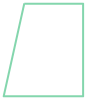

In [30]:
from shapely.geometry import shape

footprint = shape(info_s2_image["properties"]["system:footprint"])
footprint

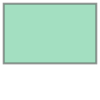

In [31]:
footprint_clip = shape(info_s2_image_sample["properties"]["system:footprint"])
footprint_clip

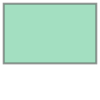

In [32]:
footprint_rect = shape(info_s2_image_sample_rect["geometry"])
footprint_rect

In [51]:
info_s2_image_sample_rect["type"]

'Feature'

In [34]:
%%time

from georeader.readers import S2_SAFE_reader

product_name = info_s2_image["properties"]["PRODUCT_ID"]
s2_safe_folder = S2_SAFE_reader.s2_public_bucket_path(product_name+".SAFE", check_exists=True)
print(f"Product {s2_safe_folder} found")
s2_obj = S2_SAFE_reader.s2loader(s2_safe_folder, out_res=10, bands=bands)
s2_obj

Product gs://gcp-public-data-sentinel-2/tiles/34/M/DB/S2B_MSIL1C_20211008T083749_N0301_R064_T34MDB_20211008T104448.SAFE found
CPU times: user 22.8 ms, sys: 3.82 ms, total: 26.6 ms
Wall time: 271 ms


 
         gs://gcp-public-data-sentinel-2/tiles/34/M/DB/S2B_MSIL1C_20211008T083749_N0301_R064_T34MDB_20211008T104448.SAFE
         Transform: | 10.00, 0.00, 399960.00|
| 0.00,-10.00, 9700000.00|
| 0.00, 0.00, 1.00|
         Shape: (9, 10980, 10980)
         Resolution: (10.0, 10.0)
         Bounds: (399960.0, 9590200.0, 509760.0, 9700000.0)
         CRS: EPSG:32734
         bands: ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12']
         fill_value_default: 0
        

In [35]:
from georeader import read
from georeader import window_utils

window_read = read.window_from_polygon(s2_obj, footprint_clip, crs_polygon="EPSG:4326", window_surrounding=True)
window_read_round = window_utils.round_outer_window(window_read)
window_read_round

Window(col_off=10254, row_off=8314, width=622, height=399)

In [36]:
window_read

Window(col_off=10254.034769492006, row_off=8314.802520980476, width=621.0774772395089, height=398.82970098406076)

In [37]:
import rasterio.windows
from rasterio import Affine

band_2_info = info_s2_image_sample["bands"][0]

transform_real_s2 = Affine(*band_2_info["crs_transform"])

window_clip = rasterio.windows.Window(col_off=band_2_info["origin"][0], row_off=band_2_info["origin"][1],
                                      width=band_2_info["dimensions"][0], height=band_2_info["dimensions"][1])
print(window_clip)
band_id = band_2_info["id"]
crs = band_2_info["crs"]
transform = rasterio.windows.transform(window_clip, transform_real_s2)
transform

Window(col_off=10254, row_off=8314, width=621, height=399)


Affine(10.0, 0.0, 502500.0,
       0.0, -10.0, 9616860.0)

In [38]:
from georeader.geotensor import GeoTensor
import numpy as np

arr = np.zeros((len(info_s2_image_sample["bands"]),window_clip.height,window_clip.width),dtype=band_2_info['data_type']["precision"])

for i, band_info in enumerate(info_s2_image_sample["bands"]):
    arr[i] = np.array(info_s2_image_sample_rect["properties"][band_info["id"]])
    
    
data_tensor = GeoTensor(arr, 
                        crs=crs, transform=transform, fill_value_default=None)
data_tensor

 
         Transform: | 10.00, 0.00, 502500.00|
| 0.00,-10.00, 9616860.00|
| 0.00, 0.00, 1.00|
         Shape: (9, 399, 621)
         Resolution: (10.0, 10.0)
         Bounds: (502500.0, 9612870.0, 508710.0, 9616860.0)
         CRS: EPSG:32734
         fill_value_default: None
        

In [39]:
data_tensor.dtype

dtype('float64')

In [40]:
%%time
data_tensor_bucket = s2_obj.read_from_window(window_read_round).load()
data_tensor_bucket

CPU times: user 3.18 s, sys: 394 ms, total: 3.58 s
Wall time: 1min 19s


 
         Transform: | 10.00, 0.00, 502500.00|
| 0.00,-10.00, 9616860.00|
| 0.00, 0.00, 1.00|
         Shape: (9, 399, 622)
         Resolution: (10.0, 10.0)
         Bounds: (502500.0, 9612870.0, 508720.0, 9616860.0)
         CRS: EPSG:32734
         fill_value_default: 0
        

In [41]:
data_tensor_bucket.dtype

dtype('uint16')

In [48]:

if data_tensor_bucket.transform != data_tensor.transform:
    print(f"Different crs {data_tensor_bucket.transform} {data_tensor.transform}")

if data_tensor_bucket.crs != data_tensor.crs:
    print(f"Different crs {data_tensor_bucket.crs} {data_tensor.crs}")

if data_tensor_bucket.shape != data_tensor.shape:
    print(f"Different shape {data_tensor_bucket.shape} {data_tensor.shape}")

Different shape (9, 399, 622) (9, 399, 621)


<AxesSubplot:>

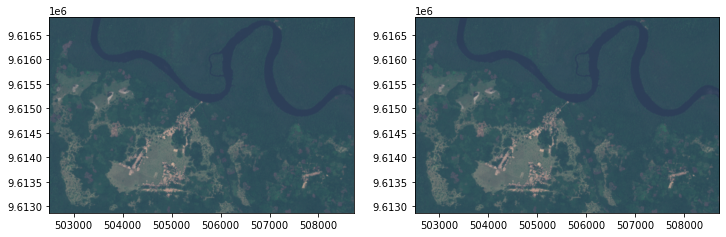

In [43]:
import rasterio.plot as rstplt
import matplotlib.pyplot as plt


rgb_bucket = np.clip(data_tensor_bucket.values[2::-1]/2_500, 0, 1)
rgb_gee = np.clip(data_tensor.values[2::-1]/2_500,0, 1)

fig, ax = plt.subplots(1,2,figsize=(12,6))

rstplt.show(rgb_bucket,ax=ax[0], transform=data_tensor_bucket.transform)
rstplt.show(rgb_gee,ax=ax[1], transform=data_tensor.transform)

In [49]:
info_s2_image_sample

{'type': 'Image',
 'bands': [{'id': 'B2',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [621, 399],
   'origin': [10254, 8314],
   'crs': 'EPSG:32734',
   'crs_transform': [10, 0, 399960, 0, -10, 9700000]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [621, 399],
   'origin': [10254, 8314],
   'crs': 'EPSG:32734',
   'crs_transform': [10, 0, 399960, 0, -10, 9700000]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [621, 399],
   'origin': [10254, 8314],
   'crs': 'EPSG:32734',
   'crs_transform': [10, 0, 399960, 0, -10, 9700000]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [621, 399],
   'origin': [10254, 8314],
   'crs': 'EPSG:32734',
   'crs_transform': [10, 0, 399960, 0, -10, 9700000]},
  {'id': 'B6',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [621, 399],
   'origin': [10254,